Things to try:

figure out best training settings for B1-4
* batch size (what's the biggest i can go with my machine?)
* increase lr according to batch size
* try lower lr for bigger archi

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# import sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/FYP')

## Key Hyperparameters & Model settings

In [ ]:
import datetime

current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%m-%d %H%MH")

model_name = input("Name your model: ")

if not model_name: model_name = "model (%s)" %formatted_datetime

PATH = 'C:/Users/chuag/OneDrive - Nanyang Technological University/Desktop/BCG 4.2/FYP/code/models/%s.pth' %model_name
PATH

In [ ]:
FF_PATH = "C:/Users/chuag/OneDrive - Nanyang Technological University/Desktop/BCG 4.2/FYP/code/data/FF++/processed/c23"
DFDC_PATH = "C:/Users/chuag/OneDrive - Nanyang Technological University/Desktop/BCG 4.2/FYP/code/data/DFDC"

categories = ["DFDC", "DeepFakeDetection", "Deepfakes", "Face2Face", "FaceShifter", "FaceSwap", "NeuralTextures", "youtube", "actors"]

dataset = {"DFDC": (0,0), # no. real | no. fake
           "DeepFakeDetection": 0,
           "Deepfakes": 0,
           "Face2Face": 0,
           "FaceShifter": 0,
           "FaceSwap": 0,
           "NeuralTextures": 7000,
           "youtube": 5000,
           "actors": 0}

sample_size = 1000
test_size = 0.15
valid_size = 0.15

In [392]:
batch_size = 32
version = "b0"
num_epochs = 100
patience = 10

In [ ]:
PRETRAINED = False
PRUNE = True
EARLYSTOP = True

In [ ]:
# choice (a) use own implementation
# choice (b) use pytorch's official implementation
# choice (c) use TIMM's efficientnet with knapsack pruning

a = "USE OWN"
b = "pytorch-effnet"
c = "TIMM effnet"

#########
USE = b
#########

In [ ]:
# Learning Rate #
lr = 0.001

# Weight Decay #
wd = 1e-05

# Choice of optimizers
o1 = "RMSPROP"
o2 = "ADAM"
o3 = "SGD"

##############
USE_OPTIM = o3
##############

# Choice of learning schedulers
s0 = None
s1 = "STEPLR"
s2 = "PLATEAU"
s3 = "COSINE"
s4 = "COSWARM"

############
USE_SCH = s3
############

# linear warm-up (no. epochs) -> set to 0 for training with no warm-up
warmup_period = 10

# If using cosine annealing with warm restarts, choose number of iterations before restart
restart_period = 10

### Fine Tuning

In [ ]:
# Custom settings for fine-tuning pretrained models
if PRETRAINED:
    num_epochs = 20
    patience = 5
    lr = 0.0001
    USE_OPTIM = o2
    USE_SCH = s2

In [5]:
# Default model settings

import torch
import torch.nn as nn
from effnet import *
from effnet import phi_values, EfficientNet

device = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = 1
classes = ["real", "fake"]

print("Using device: %s" % device)
phi, res, dropout = phi_values[version]

SIZE = res

criterion = nn.BCEWithLogitsLoss()

Using device: cuda


### Loading the model

In [6]:
efficientnet = getattr(__import__("torchvision.models", fromlist=[f"efficientnet_{version}"]), f"efficientnet_{version}")
 
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

import timm

# code to patch a pytorch effnet bug
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

def pytorch_effnet(num_classes, pretrained = False):
    if pretrained:
        model = efficientnet(weights = 'IMAGENET1K_V1')
    else:
        model = efficientnet()
    in_feats = model.classifier[1].in_features
    dropout = model.classifier[0].p
    model.classifier = nn.Sequential(nn.Dropout(dropout, inplace = True), nn.Linear(in_features=in_feats, out_features=num_classes, bias=True))

    for param in model.children():
        param.requires_grad_(True)

    model = model.to(device)
    return model

def timm_effnet(version, num_classes):
    model = timm.create_model(f'efficientnet_{version}_pruned', pretrained = True, num_classes = num_classes)
    for param in model.children():
        param.requires_grad_(True)
    
    model = model.to(device)

    return model

c:\Users\chuag\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
if USE == a:
    model = EfficientNet(version = version, num_classes = num_classes).to(device)

elif USE == b:
    model = pytorch_effnet(num_classes, pretrained = PRETRAINED)

elif USE == c:
    model = timm_effnet(version = version, num_classes = num_classes)

### Optimizers

In [324]:
## Optimizers ##
import torch.optim as optim
'''
Effnet Paper's setting (for batch size 4096)
# optimizer = optim.RMSprop(model.parameters(), weight_decay = 1e-05, alpha=0.9, lr = 0.256, momentum = 0.9)
'''

## RMSPROP Optimizer
if USE_OPTIM == o1:
    optimizer = optim.RMSprop(model.parameters(), weight_decay = lr, alpha=0.9999, lr = 0.002, momentum = 0.9)

## ADAM Optimizer
elif USE_OPTIM == o2:
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

## SGD Optimizer
elif USE_OPTIM == o3:
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)



### Learning Rate Schedulers

In [ ]:
## Schedulers ##
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts

## Effnet Paper's setting (for batch size 4096)
# scheduler = StepLR(optimizer, step_size=2.4, gamma=0.97)

step_input = False # does the scheduler require valid_loss for each step as input?
scheduler = None # use no scheduler by default
step_epoch = True # let the scheduler step at epoch (True) or mini-batch (False)?

## STEPPER Scheduler
if USE_SCH == s1:
    scheduler = StepLR(optimizer, step_size=1, gamma=0.97)

## PLATEAU Scheduler
elif USE_SCH == s2:
    step_input = True
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

## COSINE Annealing
elif USE_SCH == s3:
    scheduler = CosineAnnealingLR(optimizer, num_epochs - warmup_period)

## COSINE Annealing with Warm Restarts
elif USE_SCH == s4:
    # NOTE: scheduler takes next step over each mini-batch instead of epoch
    # REFER: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html

    step_epoch = False # update by mini-batch

    scheduler = CosineAnnealingWarmRestarts(optimizer, restart_period)


### Implement Linear Warm-up

In [325]:
import pytorch_warmup as warmup

if warmup_period > 0:
    ## Using Linear Warm up
    '''
    If you want to start the learning rate schedule after the end of the linear warmup,
    delay it by the warmup period:

        with warmup_scheduler.dampening():
            if warmup_scheduler.last_step + 1 >= warmup_period:
                lr_scheduler.step()
    '''
    warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)

else:
    warmup_scheduler = None
    

### Model Pruning
* Pruning only makes sense pre-training if we already have trained weights
* We will prune our convolution layers, followed by FC layer and seeing their effects

In [13]:
import torch.nn.utils.prune as prune

In [14]:
list(model.named_parameters())

[('features.0.0.weight',
  Parameter containing:
  tensor([[[[-5.5633e-02,  6.3881e-02, -4.1223e-02],
            [ 7.0454e-02,  1.3627e-01,  1.4498e-01],
            [-5.2837e-03,  1.1325e-01, -6.6418e-02]],
  
           [[ 1.2184e-01, -1.1149e-01, -1.4286e-01],
            [-2.9343e-02, -1.2257e-02, -2.1905e-02],
            [ 8.0713e-02,  5.7256e-02, -8.7460e-02]],
  
           [[-4.8533e-02,  4.9575e-02, -6.8938e-03],
            [ 9.6259e-02, -1.3350e-02,  1.5523e-02],
            [-7.9310e-02,  1.2802e-01,  7.0914e-02]]],
  
  
          [[[ 6.9759e-03,  2.2477e-02,  1.1502e-01],
            [ 8.1479e-02,  1.3889e-01,  9.3389e-03],
            [-1.5529e-01,  2.9051e-02, -9.3879e-02]],
  
           [[ 1.8913e-02,  9.5064e-02,  1.8989e-02],
            [ 2.6671e-02,  8.1094e-03,  1.4183e-02],
            [ 9.3655e-02, -6.4914e-02,  5.3336e-02]],
  
           [[-7.0670e-02, -9.1426e-03,  7.6858e-02],
            [ 6.3008e-02, -4.4597e-02, -1.5115e-01],
            [ 1.2907e-01, 

In [15]:
for name, param in model.named_parameters():
    print(name)

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.0.block.1.fc1.weight
features.1.0.block.1.fc1.bias
features.1.0.block.1.fc2.weight
features.1.0.block.1.fc2.bias
features.1.0.block.2.0.weight
features.1.0.block.2.1.weight
features.1.0.block.2.1.bias
features.2.0.block.0.0.weight
features.2.0.block.0.1.weight
features.2.0.block.0.1.bias
features.2.0.block.1.0.weight
features.2.0.block.1.1.weight
features.2.0.block.1.1.bias
features.2.0.block.2.fc1.weight
features.2.0.block.2.fc1.bias
features.2.0.block.2.fc2.weight
features.2.0.block.2.fc2.bias
features.2.0.block.3.0.weight
features.2.0.block.3.1.weight
features.2.0.block.3.1.bias
features.2.1.block.0.0.weight
features.2.1.block.0.1.weight
features.2.1.block.0.1.bias
features.2.1.block.1.0.weight
features.2.1.block.1.1.weight
features.2.1.block.1.1.bias
features.2.1.block.2.fc1.weight
features.2.1.block.2.fc1.bias
features.2.1.blo

In [16]:
params = []

for feature in model.features:
    for module in feature:
        if isinstance(module, nn.Linear):
            print("Found a linear layer.")

        if isinstance(module, nn.Conv2d):
            params.append((module, 'weight'))

prune.global_unstructured(params, pruning_method=prune.L1Unstructured, amount = 0.5)

In [17]:
# enforce the pruning

for module, name in params:
    prune.remove(module, name)

In [18]:
for feature in model.features:
    print(feature, type(feature))
    for module in feature:
        print(module.weight)
        break
    break

Conv2dNormActivation(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
) <class 'torchvision.ops.misc.Conv2dNormActivation'>
Parameter containing:
tensor([[[[-0.0556,  0.0639, -0.0412],
          [ 0.0705,  0.1363,  0.1450],
          [-0.0000,  0.1132, -0.0664]],

         [[ 0.1218, -0.1115, -0.1429],
          [-0.0293, -0.0000, -0.0000],
          [ 0.0807,  0.0573, -0.0875]],

         [[-0.0485,  0.0496, -0.0000],
          [ 0.0963, -0.0000,  0.0000],
          [-0.0793,  0.1280,  0.0709]]],


        [[[ 0.0000,  0.0000,  0.1150],
          [ 0.0815,  0.1389,  0.0000],
          [-0.1553,  0.0291, -0.0939]],

         [[ 0.0000,  0.0951,  0.0000],
          [ 0.0267,  0.0000,  0.0000],
          [ 0.0937, -0.0649,  0.0533]],

         [[-0.0707, -0.0000,  0.0769],
          [ 0.0630, -0.0446, -0.1512],
          [ 0.1291, -0.0870, -

In [19]:
set([i.split(".")[0] for i in model.state_dict().keys()])

{'classifier', 'features'}

### Deep Fake Data Processing

In [8]:
# Step 1. Read dir, get image paths for individual categories [ X ]
# Step 1a. Make new a class to store the three properties [ X ]
# Step 2. Train-test split the categories (80%-20%) [ X ]
# Step 3. Combine the train and test sets respectively [ X ]
# Step 3a. perform transforms for trainset [ X ]
# Step 3b. remember to include categorical labels for tracing [ X ]
# Step 4. Create data loader objects [ X ]

In [10]:
from PIL import Image

class frame():
  def __init__(self, imgpath, label, category, transform):
    self.imgpath = imgpath
    self.label = label
    self.cat = category

    self.X = transform(Image.open(imgpath).convert('RGB'))#.to(device) # - maybe this is causing crash

    if self.label == "fake": self.y = 1
    else: self.y = 0

  def values(self):
    return self.X, self.y, self.label, self.cat, self.imgpath

In [11]:
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split as TTS
import torchvision

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.Resize((SIZE, SIZE), antialias = True)
    ])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((SIZE, SIZE), antialias = True)
    ])

def TTVS(indices, test_size = 0.2, valid_size = 0.1):

  # Calculate the sizes for test and validation sets
  test_size = int(test_size * len(indices))
  valid_size = int(valid_size * len(indices))

  # Divide the indices into train, test, and validation sets
  test_indices = indices[:test_size]
  valid_indices = indices[test_size:test_size + valid_size]
  train_indices = indices[test_size + valid_size:]

  return train_indices, test_indices, valid_indices


def load(ROOT, label, category, ftype, train_transform, test_transform, test_size = 0.2, valid_size = 0.1, sample = None):
  '''
  loads data according to the origin's folder structure (DFDC differs from FF++) as frame objects
  and train test split using the sampling and transform rules provided.
  '''

  if category == "DFDC": path = os.path.join(ROOT, ftype, label)
  else: path = os.path.join(ROOT, label, category, ftype)

  train_frames = []
  test_frames = []
  valid_frames = []

  dir = os.listdir(path)

  if sample: sample_size = sample
  else: sample_size = len(dir)

  indices = random.sample(range(len(dir)), sample_size)

  train_indices, test_indices, valid_indices = TTVS(indices, test_size = test_size, valid_size = valid_size)

  for i in tqdm(train_indices):
    image_name = dir[i]
    new_frame = frame(imgpath = os.path.join(path, image_name),
                      label = label,
                      category = category,
                      transform = train_transform)
    train_frames.append(new_frame)

  for i in tqdm(test_indices):
    image_name = dir[i]
    new_frame = frame(imgpath = os.path.join(path, image_name),
                      label = label,
                      category = category,
                      transform = test_transform)
    test_frames.append(new_frame)

  for i in tqdm(valid_indices):
    image_name = dir[i]
    new_frame = frame(imgpath = os.path.join(path, image_name),
                      label = label,
                      category = category,
                      transform = test_transform)
    valid_frames.append(new_frame)

  return train_frames, test_frames, valid_frames

In [13]:
training = []
testing = []
validation = []

In [ ]:
## Deep Fake Detection Challenge (preprocessed) ##

if dataset["DFDC"][0] > 0:
    DFDC_real_train, DFDC_real_test, DFDC_real_valid = load(DFDC_PATH, "real", "DFDC", "train", train_transform, test_transform, test_size, valid_size, dataset["DFDC"][0])
    DFDC_fake_train, DFDC_fake_test, DFDC_fake_valid = load(DFDC_PATH, "fake", "DFDC", "train", train_transform, test_transform, test_size, valid_size, dataset["DFDC"][1])

    training = training + DFDC_real_train + DFDC_fake_train
    testing = testing + DFDC_real_test + DFDC_fake_test
    validation = validation + DFDC_real_valid + DFDC_fake_valid

In [14]:
### This two datasets should go together

## ACTORS (untampered original videos of DeepFakeDetection)
if dataset["actors"] > 0:
    ACTORS_train, ACTORS_test, ACTORS_valid = load(FF_PATH,"real","actors","faces",train_transform,test_transform,test_size,valid_size,dataset["actors"])
    
    training = training + ACTORS_train
    testing = testing  + ACTORS_test
    validation = validation + ACTORS_valid

## DeepFakeDetection dataset
if dataset["DeepFakeDetection"] > 0:
    DFD_train, DFD_test, DFD_valid = load(FF_PATH,"fake","DeepFakeDetection","faces",train_transform,test_transform,test_size,valid_size,dataset["DeepFakeDetection"])

    training = training + DFD_train
    testing = testing + DFD_test 
    validation = validation + DFD_valid

100%|██████████| 1749/1749 [00:13<00:00, 128.11it/s]


In [12]:
## FaceForensics (untampered original videos of FF++)
if dataset["youtube"] > 0:
    YT_train, YT_test, YT_valid = load(FF_PATH,"real","youtube","faces",train_transform,test_transform,test_size,valid_size,dataset["youtube"])

    training = training + YT_train
    testing = testing + YT_test
    validation = validation + YT_valid

100%|██████████| 1050/1050 [00:05<00:00, 201.89it/s]


In [ ]:
## FF++: DeepFakes
if dataset["Deepfakes"] > 0:
    DF_train, DF_test, DF_valid = load(FF_PATH,"fake","Deepfakes","faces",train_transform,test_transform,test_size,valid_size,dataset["Deepfakes"])

    training = training + DF_train
    testing = testing + DF_test
    validation = validation + DF_valid

  0%|          | 0/6347 [00:00<?, ?it/s]

100%|██████████| 1360/1360 [00:06<00:00, 204.51it/s]


In [13]:
## FF++: Face2Face
if dataset["Face2Face"] > 0:
    F2F_train, F2F_test, F2F_valid = load(FF_PATH,"fake","Face2Face","faces",train_transform,test_transform,test_size,valid_size,dataset["Face2Face"])

    training = training + F2F_train
    testing = testing + F2F_test
    validation = validation + F2F_valid

  0%|          | 0/6624 [00:00<?, ?it/s]

100%|██████████| 1419/1419 [00:03<00:00, 376.59it/s]


In [ ]:
## FF++: FaceShifter
if dataset["FaceShifter"] > 0:
    SHIFTER_train, SHIFTER_test, SHIFTER_valid = load(FF_PATH,"fake","FaceShifter","faces",train_transform,test_transform,test_size,valid_size,dataset["FaceShifter"])

    training = training + SHIFTER_train
    testing = testing + SHIFTER_test
    validation = validation + SHIFTER_valid

In [ ]:
## FF++: FaceSwap
if dataset["FaceSwap"] > 0:
    SWAP_train, SWAP_test, SWAP_valid = load(FF_PATH,"fake","FaceSwap","faces",train_transform,test_transform,test_size,valid_size,dataset["FaceSwap"])

    training = training + SWAP_train
    testing = testing + SWAP_test
    validation = validation + SWAP_valid

In [ ]:
## FF++: NeuralTextures
if dataset["NeuralTextures"] > 0:
    NT_train, NT_test, NT_valid = load(FF_PATH,"fake","NeuralTextures","faces",train_transform,test_transform,test_size,valid_size,dataset["NeuralTextures"])

    training = training + NT_train
    testing = testing + NT_test
    validation = validation + NT_valid

In [15]:
random.shuffle(training)
random.shuffle(testing)
random.shuffle(validation)

In [16]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, frames):
      self.frames = frames

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        return self.frames[idx].values()

trainset = CustomDataset(training)
testset = CustomDataset(testing)
validset = CustomDataset(validation)

trainloader = DataLoader(trainset, batch_size = batch_size)
testloader = DataLoader(testset, batch_size = batch_size)
validloader = DataLoader(validset, batch_size = batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


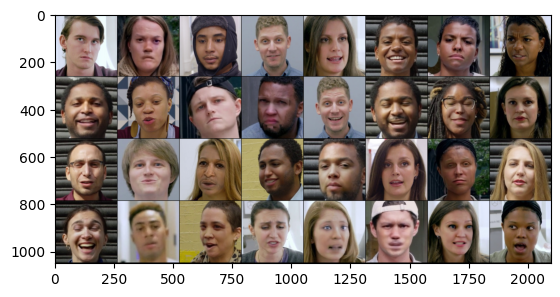

real  fake  real  real  real  real  fake  real  fake  real  real  fake  real  fake  fake  fake  fake  real  fake  fake  fake  real  fake  real  fake  fake  fake  fake  fake  fake  fake  real 


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
X, Y, labels, cats, paths = next(dataiter)

imshow(torchvision.utils.make_grid(X[:batch_size]))

print(' '.join(f'{labels[j]:5s}' for j in range(batch_size)))

### Model Training

In [18]:
# early stopping logic
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0, model = None):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [19]:
def call_scheduler(scheduler, warmup_scheduler = None, require_input = False, sch_input = None):
    # STEP THE LEARNING RATE USING SCHEDULER #
    '''
    returns 'warmed' -> True: warmup is over | False: warming up
    '''

    if warmup_scheduler:
        with warmup_scheduler.dampening():
            if warmup_scheduler.last_step + 1 >= warmup_period:

                if scheduler and require_input:
                    scheduler.step(sch_input)

                elif scheduler:
                    scheduler.step()
                
                return True # early_stop = True
            
            else:
                return False # do not early stop during linear warm up
            
    else:
        if scheduler and step_input: scheduler.step(sch_input)
        elif scheduler: scheduler.step()

    return True

In [20]:
from tqdm import tqdm

def train(model, criterion, optimizer, early_stop = True,
          scheduler = None, step_input = False, step_epoch = True,
          warmup_scheduler = None, warmup_period = 0,
          num_epochs = 50, patience = 3, PATH = None):
    '''
    inputs -
    model: model to be trained
    criterion: loss fn
    optimizer: learning optimizer
    early_stop: do early stopping
    scheduler: learning scheduler
    step_input: if True: scheduler's step requires valid_loss as input
    step_epoch: if True: scheduler should step every epoch | if False: scheduler will step every mini-batch
    warmup_scheduler: warm up scheduler
    warmup_period: no. cycles before restart
    epochs: number of epochs to train for
    patience: early stopping patience
    PATH: to save model
    '''
    earlystopper = EarlyStopper(patience=patience)

    train_losses = []
    train_acc = []
    valid_losses = []
    valid_acc = []
    learning_rates = []

    min_validation_loss = np.inf
    best_model = model.state_dict()
    best_epoch = -1

    for epoch in range(num_epochs):

        # training
        model.train()
        running_loss = 0.0
        iter_size = 0
        correct_train = 0
        total_train = 0

        for i, V  in enumerate(tqdm(trainloader)):
            X, Y, _, _, _ = V
            optimizer.zero_grad()

            logits = model(X.to(device))
            # BCELoss sigmoids for you, just give it logits
            loss = criterion(logits, Y.unsqueeze(1).float().to(device))
            loss.backward()
            optimizer.step()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            running_loss += loss.item()

            out = torch.sigmoid(logits)
            pred = (out > 0.5).float()
            total_train += Y.size(0)
            results = pred.squeeze() == Y.to(device)
            correct_train += (results).sum().item()

            iter_size += 1

            if not step_epoch: # used for COSINE annealing w/ warm restarts
                warmed = call_scheduler(scheduler, warmup_scheduler, step_input, (epoch + i - warmup_period / len(trainloader)))

        train_accuracy = 100 * float(correct_train / total_train)
        train_loss = running_loss/iter_size

        train_acc.append(train_accuracy)
        train_losses.append(train_loss)

        lr = optimizer.param_groups[0]['lr']
        learning_rates.append(lr)
        
        print(f"[epoch: {epoch + 1}] loss: {train_loss:.3f} acc: {train_accuracy:.1f}% LR: {lr}")
        # if scheduler: print(f"Scheduler - LR: {scheduler.get_last_lr()}")
        
        if PATH: torch.save(model.state_dict(), PATH) # save the model every epoch

        # evaluation
        model.eval()

        running_loss = 0.0
        iter_size = 0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for X, Y, _, _, _ in validloader:
                logits = model(X.to(device))
                loss = criterion(logits, Y.unsqueeze(1).float().to(device))
                running_loss += loss.item()
                
                out = torch.sigmoid(logits)
                pred = (out > 0.5).float()
                total_test += Y.size(0)
                results = pred.squeeze() == Y.to(device)
                correct_test += (results).sum().item()

                iter_size += 1

            valid_accuracy = 100 * float(correct_test / total_test)
            valid_loss = running_loss/iter_size
            valid_acc.append(valid_accuracy)
            valid_losses.append(valid_loss)

            print(f'validation loss: <{valid_loss:.3f}> acc: {valid_accuracy:.1f}%')

        # STEP THE LEARNING RATE USING SCHEDULER #
        if step_epoch:
            warmed = call_scheduler(scheduler, warmup_scheduler, step_input, valid_loss)

        # SAVE the best model seen so far #
        if valid_loss < min_validation_loss:
            min_validation_loss = valid_loss
            best_model = model.state_dict()
            best_epoch = epoch + 1
            if epoch != 0: print(">>> found model improvement <<<")
        
        # EARLY STOPPING #
        if early_stop and warmed and earlystopper.early_stop(valid_loss, model):
            print("Stopping training early due to validation loss exceeding patience.")
            break

    if PATH: # loads best model version found during training
        torch.save(best_model, PATH)
        # model.load_state_dict(torch.load(PATH))
        model.load_state_dict(best_model)
        print("Loading Best Model found at Epoch %s" % best_epoch)

    print('training complete')
    return train_losses, train_acc, valid_losses, valid_acc, learning_rates

In [22]:
model_stats = train(model = model, criterion = criterion,
                    optimizer = optimizer, scheduler = scheduler,
                    step_epoch = step_epoch, step_input = step_input,
                    warmup_scheduler = warmup_scheduler, warmup_period= warmup_period,
                    num_epochs = num_epochs, patience = patience, early_stop = EARLYSTOP,
                    PATH = PATH)

train_losses, train_acc, valid_losses, valid_acc, learning_rates = model_stats

torch.save(model.state_dict(), PATH)

100%|██████████| 417/417 [01:46<00:00,  3.93it/s]


[epoch: 1] loss: 0.676 acc: 60.0% LR: 0.001
validation loss: <0.691> acc: 61.2%


100%|██████████| 417/417 [01:49<00:00,  3.82it/s]


[epoch: 2] loss: 0.678 acc: 60.8% LR: 0.002
validation loss: <0.674> acc: 61.2%


100%|██████████| 417/417 [01:51<00:00,  3.73it/s]


[epoch: 3] loss: 0.680 acc: 60.5% LR: 0.003
validation loss: <0.686> acc: 61.5%


100%|██████████| 417/417 [01:50<00:00,  3.76it/s]


[epoch: 4] loss: 0.680 acc: 60.3% LR: 0.004
validation loss: <0.667> acc: 61.2%


100%|██████████| 417/417 [01:48<00:00,  3.83it/s]


[epoch: 5] loss: 0.683 acc: 60.5% LR: 0.005
validation loss: <0.671> acc: 61.4%


100%|██████████| 417/417 [01:49<00:00,  3.82it/s]


[epoch: 6] loss: 0.685 acc: 60.0% LR: 0.006
validation loss: <0.732> acc: 60.3%


100%|██████████| 417/417 [01:50<00:00,  3.78it/s]


[epoch: 7] loss: 0.684 acc: 60.0% LR: 0.006999999999999999
validation loss: <0.680> acc: 60.5%


100%|██████████| 417/417 [01:50<00:00,  3.77it/s]


[epoch: 8] loss: 0.681 acc: 60.1% LR: 0.008
validation loss: <0.719> acc: 61.4%


100%|██████████| 417/417 [01:50<00:00,  3.77it/s]


[epoch: 9] loss: 0.677 acc: 60.6% LR: 0.009000000000000001
validation loss: <0.679> acc: 59.3%


100%|██████████| 417/417 [01:50<00:00,  3.77it/s]


[epoch: 10] loss: 0.674 acc: 60.7% LR: 0.01
validation loss: <0.663> acc: 61.5%


100%|██████████| 417/417 [01:50<00:00,  3.77it/s]


[epoch: 11] loss: 0.665 acc: 61.2% LR: 0.0009755282581475768
validation loss: <0.660> acc: 61.8%


100%|██████████| 417/417 [01:49<00:00,  3.81it/s]


[epoch: 12] loss: 0.661 acc: 61.6% LR: 0.0009045084971874737
validation loss: <0.657> acc: 62.4%


100%|██████████| 417/417 [01:48<00:00,  3.83it/s]


[epoch: 13] loss: 0.657 acc: 62.1% LR: 0.0007938926261462366
validation loss: <0.650> acc: 63.3%


100%|██████████| 417/417 [01:50<00:00,  3.79it/s]


[epoch: 14] loss: 0.652 acc: 62.2% LR: 0.0006545084971874737
validation loss: <0.645> acc: 63.7%


100%|██████████| 417/417 [01:50<00:00,  3.78it/s]


[epoch: 15] loss: 0.650 acc: 62.4% LR: 0.0005
validation loss: <0.644> acc: 63.4%


100%|██████████| 417/417 [01:50<00:00,  3.77it/s]


[epoch: 16] loss: 0.647 acc: 62.8% LR: 0.00034549150281252633
validation loss: <0.639> acc: 64.1%


100%|██████████| 417/417 [01:50<00:00,  3.78it/s]


[epoch: 17] loss: 0.642 acc: 63.8% LR: 0.00020610737385376348
validation loss: <0.633> acc: 64.7%


100%|██████████| 417/417 [01:50<00:00,  3.78it/s]


[epoch: 18] loss: 0.639 acc: 64.7% LR: 9.549150281252633e-05
validation loss: <0.632> acc: 65.0%


100%|██████████| 417/417 [01:50<00:00,  3.79it/s]


[epoch: 19] loss: 0.638 acc: 64.0% LR: 2.4471741852423235e-05
validation loss: <0.632> acc: 65.2%


100%|██████████| 417/417 [01:47<00:00,  3.89it/s]


[epoch: 20] loss: 0.643 acc: 63.3% LR: 0.001
validation loss: <0.631> acc: 64.8%


100%|██████████| 417/417 [01:46<00:00,  3.91it/s]


[epoch: 21] loss: 0.632 acc: 64.6% LR: 0.0009755282581475768
validation loss: <0.617> acc: 65.7%


100%|██████████| 417/417 [01:46<00:00,  3.91it/s]


[epoch: 22] loss: 0.621 acc: 65.8% LR: 0.0009045084971874737
validation loss: <0.619> acc: 66.8%


100%|██████████| 417/417 [01:46<00:00,  3.90it/s]


[epoch: 23] loss: 0.601 acc: 67.4% LR: 0.0007938926261462366
validation loss: <0.580> acc: 70.2%


100%|██████████| 417/417 [01:46<00:00,  3.90it/s]


[epoch: 24] loss: 0.577 acc: 69.9% LR: 0.0006545084971874737
validation loss: <0.559> acc: 71.5%


100%|██████████| 417/417 [01:46<00:00,  3.91it/s]


[epoch: 25] loss: 0.558 acc: 71.6% LR: 0.0005
validation loss: <0.543> acc: 73.2%


100%|██████████| 417/417 [01:46<00:00,  3.90it/s]


[epoch: 26] loss: 0.534 acc: 73.3% LR: 0.00034549150281252633
validation loss: <0.523> acc: 74.0%


100%|██████████| 417/417 [01:46<00:00,  3.91it/s]


[epoch: 27] loss: 0.511 acc: 74.7% LR: 0.00020610737385376348
validation loss: <0.522> acc: 74.4%


100%|██████████| 417/417 [01:46<00:00,  3.91it/s]


[epoch: 28] loss: 0.498 acc: 76.1% LR: 9.549150281252633e-05
validation loss: <0.483> acc: 76.6%


100%|██████████| 417/417 [01:46<00:00,  3.91it/s]


[epoch: 29] loss: 0.489 acc: 76.6% LR: 2.4471741852423235e-05
validation loss: <0.478> acc: 76.7%


100%|██████████| 417/417 [01:46<00:00,  3.91it/s]


[epoch: 30] loss: 0.522 acc: 73.7% LR: 0.001
validation loss: <0.521> acc: 74.6%


100%|██████████| 417/417 [01:46<00:00,  3.92it/s]


[epoch: 31] loss: 0.492 acc: 76.2% LR: 0.0009755282581475768
validation loss: <0.440> acc: 79.3%


100%|██████████| 417/417 [01:46<00:00,  3.93it/s]


[epoch: 32] loss: 0.459 acc: 78.3% LR: 0.0009045084971874737
validation loss: <0.405> acc: 81.3%


100%|██████████| 417/417 [01:46<00:00,  3.90it/s]


[epoch: 33] loss: 0.424 acc: 80.1% LR: 0.0007938926261462366
validation loss: <0.399> acc: 81.7%


100%|██████████| 417/417 [01:46<00:00,  3.90it/s]


[epoch: 34] loss: 0.394 acc: 81.9% LR: 0.0006545084971874737
validation loss: <0.376> acc: 83.4%


100%|██████████| 417/417 [01:46<00:00,  3.91it/s]


[epoch: 35] loss: 0.366 acc: 83.5% LR: 0.0005
validation loss: <0.415> acc: 80.8%


100%|██████████| 417/417 [01:45<00:00,  3.94it/s]


[epoch: 36] loss: 0.340 acc: 84.9% LR: 0.00034549150281252633
validation loss: <0.379> acc: 83.3%


100%|██████████| 417/417 [01:45<00:00,  3.94it/s]


[epoch: 37] loss: 0.312 acc: 86.2% LR: 0.00020610737385376348
validation loss: <0.358> acc: 83.8%


100%|██████████| 417/417 [01:45<00:00,  3.94it/s]


[epoch: 38] loss: 0.290 acc: 87.1% LR: 9.549150281252633e-05
validation loss: <0.367> acc: 83.3%


100%|██████████| 417/417 [01:46<00:00,  3.93it/s]


[epoch: 39] loss: 0.281 acc: 88.0% LR: 2.4471741852423235e-05
validation loss: <0.354> acc: 84.1%


100%|██████████| 417/417 [01:46<00:00,  3.93it/s]


[epoch: 40] loss: 0.364 acc: 83.4% LR: 0.001
validation loss: <0.376> acc: 83.1%


100%|██████████| 417/417 [01:45<00:00,  3.94it/s]


[epoch: 41] loss: 0.335 acc: 85.2% LR: 0.0009755282581475768
validation loss: <0.468> acc: 80.0%


100%|██████████| 417/417 [01:45<00:00,  3.94it/s]


[epoch: 42] loss: 0.313 acc: 86.2% LR: 0.0009045084971874737
validation loss: <0.444> acc: 80.7%


100%|██████████| 417/417 [01:45<00:00,  3.93it/s]


[epoch: 43] loss: 0.282 acc: 87.7% LR: 0.0007938926261462366
validation loss: <0.462> acc: 82.1%


100%|██████████| 417/417 [01:45<00:00,  3.94it/s]


[epoch: 44] loss: 0.253 acc: 89.1% LR: 0.0006545084971874737
validation loss: <0.534> acc: 80.4%


100%|██████████| 417/417 [01:45<00:00,  3.94it/s]


[epoch: 45] loss: 0.229 acc: 90.1% LR: 0.0005
validation loss: <0.417> acc: 83.4%


100%|██████████| 417/417 [01:45<00:00,  3.94it/s]


[epoch: 46] loss: 0.205 acc: 91.3% LR: 0.00034549150281252633
validation loss: <0.356> acc: 85.9%


100%|██████████| 417/417 [01:45<00:00,  3.94it/s]


[epoch: 47] loss: 0.180 acc: 92.6% LR: 0.00020610737385376348
validation loss: <0.415> acc: 83.6%


100%|██████████| 417/417 [01:45<00:00,  3.94it/s]


[epoch: 48] loss: 0.160 acc: 93.7% LR: 9.549150281252633e-05
validation loss: <0.367> acc: 85.2%


100%|██████████| 417/417 [01:45<00:00,  3.93it/s]


[epoch: 49] loss: 0.153 acc: 93.9% LR: 2.4471741852423235e-05
validation loss: <0.376> acc: 85.9%
Stopping training early due to validation loss exceeding patience.
training complete


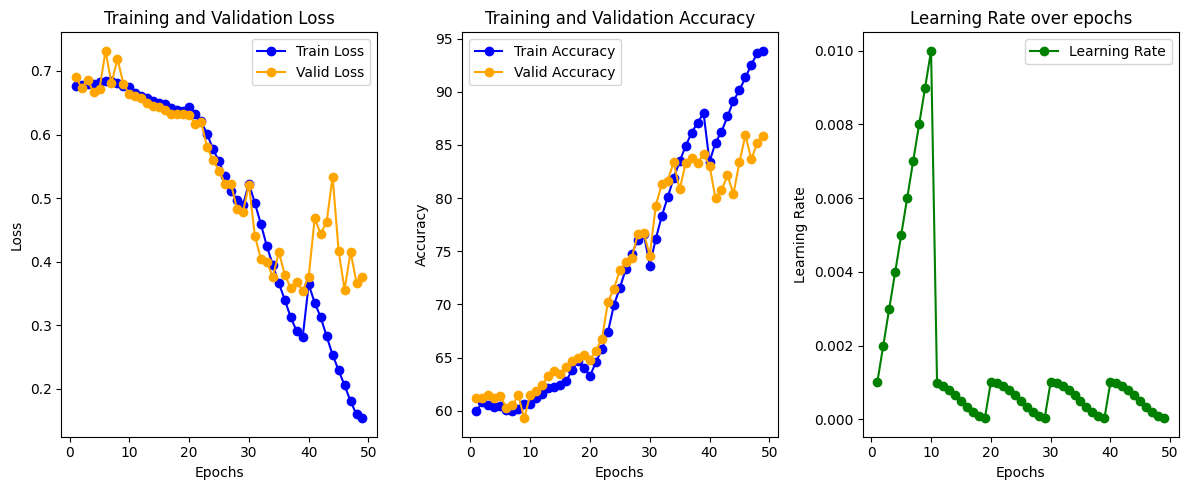

In [23]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, valid_losses, label='Valid Loss', color='orange', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracies
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
    plt.plot(epochs, valid_accuracies, label='Valid Accuracy', color='orange', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Learning Rates
    plt.subplot(1, 3, 3)
    plt.plot(epochs, learning_rates , label='Learning Rate', color='green', marker='o')
    plt.title('Learning Rate over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# train_losses, valid_losses, train_accuracies, valid_accuracies are lists containing
# loss and accuracy values for each epoch during training and validation.
plot_learning_curve(train_losses, valid_losses, train_acc, valid_acc)

In [ ]:
# import gc

# obj = None
# gc.collect() # Python thing

In [ ]:
# torch.cuda.empty_cache() # PyTorch thing

In [ ]:
# 1/0

## Model Performance

In [ ]:
# LOAD SAVED MODEL
USE = b

if USE == a:
  model = EfficientNet(version, num_classes).to(device)
elif USE == b:
  model = pytorch_effnet(num_classes=num_classes)
elif USE == c:
  model = timm_effnet(version=version, num_classes=num_classes)
  
model_path = input("Enter path of model to load: ")

if not model_path:
  model_path = PATH
model.load_state_dict(torch.load(model_path, map_location = torch.device('cpu')))

In [25]:
correct = 0
total = 0
categories = ["DFDC", "DeepFakeDetection", "Deepfakes", "Face2Face", "FaceShifter", "FaceSwap", "NeuralTextures", "youtube", "actors"]
cat_correct = {cat:0 for cat in categories}
cat_total = {cat:0 for cat in categories}

actual = []
predictions = []

def compare(cat_total, cat_correct, categories, results):
  for i, result in enumerate(results):
    if result: # if correct
      cat_correct[categories[i]] += 1
    cat_total[categories[i]] += 1

  return cat_correct, cat_total

# since we're not training, we don't need to calculate the gradients for our outputs
model.eval()
with torch.no_grad():
    for data in tqdm(testloader):
        X, Y, labels, cats, _ = data
        # calculate outputs by running images through the network
        logits = model(X.to(device))
        out = torch.sigmoid(logits)
        pred = (out > 0.5).float() #binary classification: <= 0.5: 0 ; > 0.5: 1
        total += Y.size(0)
        results = pred.squeeze() == Y.to(device)
        correct += (results).sum().item()
        cat_correct, cat_total = compare(cat_total, cat_correct, cats, results)

        actual += [int(x) for x in Y]
        predictions += [int(x) for x in pred]

print(f'\nAccuracy of the network on tested frames: {100 * correct // total} %')

# print accuracy for each class
for category, correct_count in cat_correct.items():
    if cat_total[category] != 0:
      accuracy = 100 * float(correct_count) / cat_total[category]
      print(f'Accuracy for class: {category:5s} is {accuracy:.2f}%')

100%|██████████| 90/90 [00:07<00:00, 12.28it/s]


Accuracy of the network on tested frames: 86 %
Accuracy for class: DeepFakeDetection is 90.22%
Accuracy for class: actors is 79.58%


Text(0.5, 23.52222222222222, '\n\nAccuracy=0.861\nPrecision=0.875\nRecall=0.902\nF1 Score=0.888')

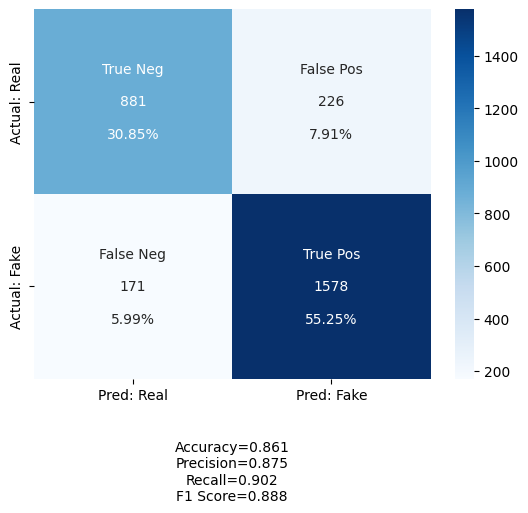

: 

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(actual, predictions)

def compute_stats(cm):
    '''confusion matrix object must be binary'''
    #Accuracy is sum of diagonal divided by total observations
    accuracy  = np.trace(cm) / float(np.sum(cm))

    #Metrics for Binary Confusion Matrices
    precision = cm[1,1] / sum(cm[:,1])
    recall    = cm[1,1] / sum(cm[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
        accuracy,precision,recall,f1_score)
        
    return stats_text

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1,v2,v3 in zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)
category1 = ["Actual: Real","Actual: Fake"]
category2 = ["Pred: Real","Pred: Fake"]

sns.heatmap(cm, annot=labels, 
            fmt='', cmap='Blues', xticklabels=category2, yticklabels=category1)

plt.xlabel(compute_stats(cm))

In [ ]:
correct, total

(1882, 2469)

In [ ]:
from torchinfo import summary

summary(model2, input_size=(batch_size, 3, SIZE, SIZE))

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [16, 1]                   --
├─Conv2dSame: 1-1                             [16, 32, 120, 120]        864
├─BatchNormAct2d: 1-2                         [16, 32, 120, 120]        64
│    └─Identity: 2-1                          [16, 32, 120, 120]        --
│    └─SiLU: 2-2                              [16, 32, 120, 120]        --
├─Sequential: 1-3                             [16, 320, 8, 8]           --
│    └─Sequential: 2-3                        [16, 16, 120, 120]        --
│    │    └─DepthwiseSeparableConv: 3-1       [16, 16, 120, 120]        1,448
│    │    └─DepthwiseSeparableConv: 3-2       [16, 16, 120, 120]        612
│    └─Sequential: 2-4                        [16, 12, 60, 60]          --
│    │    └─InvertedResidual: 3-3             [16, 12, 60, 60]          2,428
│    │    └─InvertedResidual: 3-4             [16, 12, 60, 60]          3,130
│    │   

In [ ]:
model2 = timm_effnet(version=version,num_classes=num_classes).to(device)

In [ ]:
from torchsummary import summary

summary(model, (3, SIZE, SIZE), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 32, 130, 130]             864
       BatchNorm2d-2         [16, 32, 130, 130]              64
              SiLU-3         [16, 32, 130, 130]               0
            Conv2d-4         [16, 32, 130, 130]             288
       BatchNorm2d-5         [16, 32, 130, 130]              64
              SiLU-6         [16, 32, 130, 130]               0
 AdaptiveAvgPool2d-7             [16, 32, 1, 1]               0
            Conv2d-8              [16, 8, 1, 1]             264
              SiLU-9              [16, 8, 1, 1]               0
           Conv2d-10             [16, 32, 1, 1]             288
          Sigmoid-11             [16, 32, 1, 1]               0
SqueezeExcitation-12         [16, 32, 130, 130]               0
           Conv2d-13         [16, 16, 130, 130]             512
      BatchNorm2d-14         [16, 16, 1